In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [67]:
report_database = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])

In [58]:
# Wskaźniki rentowności
def calculationReturnOnAssets(df : pd.DataFrame) -> np.ndarray:
    return (df["Zysk netto"] * 100 / (df["Aktywa trwałe"] + 
                                      df["Aktywa obrotowe"])).to_numpy()

def calculationReturnOnEquity(df : pd.DataFrame) -> np.ndarray:
    return (df["Zysk netto"] * 100 / (df["Kapitał (fundusz) podstawowy"] + 
                                      df["Kapitał (fundusz) zapasowy"])).to_numpy()

# Wskaźniki płynności
def calculationCurrentRatio(df : pd.DataFrame) -> np.ndarray:
    return (df["Aktywa obrotowe"] / df["Zobowiązania krótkoterminowe"]).to_numpy()

def calculationQuickRatio(df : pd.DataFrame) -> np.ndarray:
    return ((df["Aktywa obrotowe"] - df["Zapasy"])/df["Zobowiązania krótkoterminowe"]).to_numpy()

def calculationCashRatio(df : pd.DataFrame) -> np.ndarray:
    return (df["Inwestycje krótkoterminowe"]/df["Zobowiązania krótkoterminowe"]).to_numpy()

# Wskaźniki zadłużenia
def calculationDebtRatio(df : pd.DataFrame) -> np.ndarray:
    return ((df["Zobowiązania długoterminowe"] + df["Zobowiązania krótkoterminowe"])/
            (df["Aktywa trwałe"] + df["Aktywa obrotowe"])).to_numpy()

def calculationDebtToEquityRatio(df : pd.DataFrame) -> np.ndarray:
    return ((df["Zobowiązania długoterminowe"] + df["Zobowiązania krótkoterminowe"])/
            (df["Kapitał (fundusz) podstawowy"] + df["Kapitał (fundusz) zapasowy"])).to_numpy()

# Wskaźniki efektywności (sprawności działania)
def calculationEBITDA(df : pd.DataFrame) -> np.ndarray:
    return (df["Zysk operacyjny (EBIT)"] + df["Amortyzacja"]).to_numpy()

def calculationEBIT(df : pd.DataFrame) -> np.ndarray:
    return df["Zysk operacyjny (EBIT)"].to_numpy()


In [168]:
report_index = pd.DataFrame(
    columns=[
        "ReturnOnAssets", 
        "ReturnOnEquity",  
        "CurrentRatio", 
        "QuickRatio", 
        "CashRatio", 
        "DebtRatio", 
        "DebtToEquityRatio",
        "EBITDA",
        "EBIT"
        ], 
    data=np.array([
        calculationReturnOnAssets(report_database),
        calculationReturnOnEquity(report_database),
        calculationCurrentRatio(report_database),
        calculationQuickRatio(report_database),
        calculationCashRatio(report_database),
        calculationDebtRatio(report_database),
        calculationDebtToEquityRatio(report_database),
        calculationEBITDA(report_database),
        calculationEBIT(report_database)
        ]).T,
    index = report_database.index)

### Korelacja indeksów

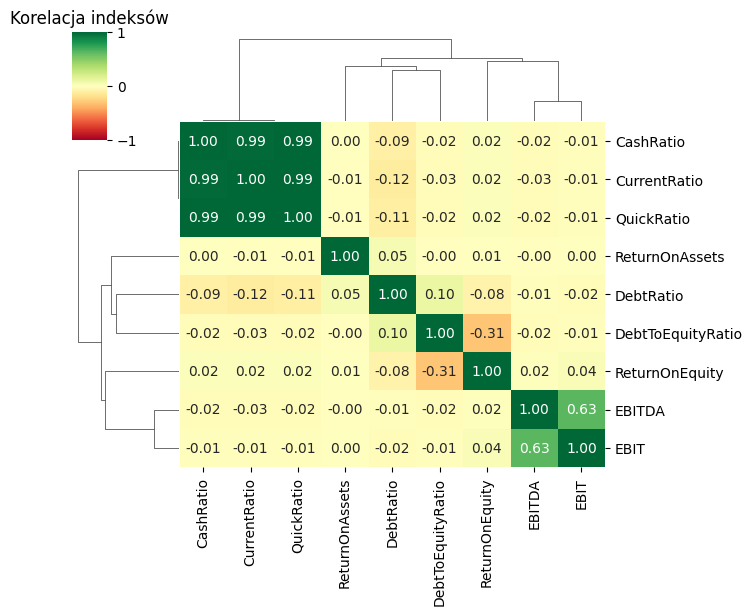

In [187]:
sns.clustermap(report_index.corr(), cmap='RdYlGn', vmin=-1, vmax=1, 
               fmt='.2f', annot=True, figsize=(7, 6))
plt.title("Korelacja indeksów", loc="center")
plt.show()

In [190]:
report_index = report_index.drop(columns=["QuickRatio", "CashRatio"])

### Próba uczenia maszynowego

In [82]:
from scipy import stats
def castToCategorical(x, n_category):
    mean = np.mean(x)
    std = np.std(x)
    site_points = stats.norm.ppf(np.arange(0,n_category) * 0.5 / n_category, loc=mean, scale=std)
    divide_points = np.concatenate([site_points,-site_points[::-1]])
    return pd.cut(x, bins=divide_points, labels=np.arange(-n_category+1,n_category))
    

In [142]:
avg_return = pd.read_csv("../database/mergedData/Annual_AVG_RET.csv", index_col=[0])
database = report_index.dropna()
avg_return = avg_return.dropna()

concat_database = pd.concat([database, avg_return["AVG_14D"]], axis=1, join="inner") 
concat_database["AVG_14D"] = castToCategorical(concat_database["AVG_14D"], 3)

In [147]:
from sklearn.model_selection import train_test_split

TARGET = 'AVG_14D'
df_train, df_test = train_test_split(concat_database,
                            train_size=2/3,
                            stratify=concat_database[TARGET])

X_train = df_train.to_numpy()[:,:-1]
y_train = df_train[TARGET].to_numpy()

X_test = df_test.to_numpy()[:,:-1]
y_test = df_test[TARGET].to_numpy()

In [166]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 250,
                            max_depth = 10,
                            n_jobs = -1)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=250, n_jobs=-1)

ACC = 0.5980392156862745


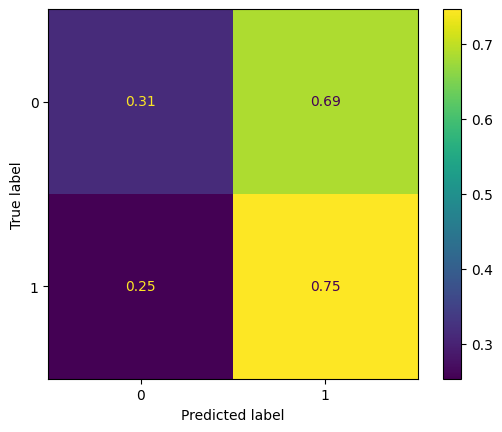

In [167]:
from sklearn import metrics 
y_pred = rf.predict(X_test)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_test, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_test, y_pred, labels=rf.classes_, normalize='true')

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Szeroki horyzont obserwacji

W krótkim horyzoncie obserwacji wokół dnia publikacji sprawozdania finansowego nie zauważono istotnych statystycznie zmian.
Z tego powodu postanowiono rozszerzyć horyzont obserwacji na dłuższy okres.

Założenia:
   

In [611]:
from enum import Enum
import yfinance as yf 


class StockPrices:
    class HistoricalType(Enum):
        BEFORE = 0
        AFTER = 1

    def __init__(self) -> None:
        self._POSTFIX = ".WA"
        self._yFinanceHandler = None
        self._ticker = None 
        self._historical_price = None
        
    def __readHistoricalStockPrice(self, 
                                   ticker : str) -> None:
        if self._ticker == ticker:
            return
        
        self._ticker = ticker
        self._yFinanceHandler = yf.Ticker(f"{self._ticker}{self._POSTFIX}")
        self._historical_price = self._yFinanceHandler.history(period="max", interval="1d")
        self.__reduceUTCTypeTime()
    
    def __reduceUTCTypeTime(self) -> None:
        if self._historical_price.empty:
            return
        self._historical_price.index = list(map(lambda x : np.datetime64(str(x)[:10]), 
                                               self._historical_price.index))
        
    def __getIndexDate(self, date : np.datetime64) -> int :
        if self._historical_price.empty:
            return None

        try:
            return self._historical_price.index.get_loc(date)
        except:
            return None
    
    def getHistoricalBefore(self, ticker : str, date : np.datetime64,
                            offset : int, period : int) -> pd.DataFrame:
        self.__readHistoricalStockPrice(ticker)
        index = self.__getIndexDate(date)
        if index == None:
            return pd.DataFrame([])
        selected_pd = self._historical_price.iloc[index-offset-period+1 : index-offset+1]
        if selected_pd.shape[0] != period:
            return pd.DataFrame([])
        return selected_pd
            

    def getHistoricalAfter(self, ticker : str, date : np.datetime64,
                           offset : int, period : int) -> pd.DataFrame:
        self.__readHistoricalStockPrice(ticker)
        index = self.__getIndexDate(date)
        if index == None:
            return pd.DataFrame([])
        selected_pd = self._historical_price.iloc[index+offset : index+offset+period]
        if selected_pd.shape[0] != period:
            return pd.DataFrame([])
        return selected_pd

    def getHistorical(self,
                      ticker : str, 
                      historicalType : HistoricalType,
                      date : np.datetime64,
                      offset : int, 
                      period : int) -> pd.DataFrame:
        
        if historicalType == StockPrices.HistoricalType.AFTER:
            return self.getHistoricalAfter(ticker, date, offset, period)
        else:
            return self.getHistoricalBefore(ticker, date, offset, period)
        
    def getYearlyHistorical(self,
                            ticker : str, 
                            date : int):
        year_str = date.astype('datetime64[Y]').astype(int) + 1970
        date_begin = np.datetime64(f"{year_str}-01-01")
        date_end = np.datetime64(f"{year_str}-12-31")
        self.__readHistoricalStockPrice(ticker)
        return self._historical_price[np.all([self._historical_price.index > date_begin, 
                                              self._historical_price.index <= date_end], 
                                              axis=0)]


class StockPricesPreprocessing:
    class PriceType(Enum):
        OPEN = "Open"
        CLOSE = "Close"
        VOLUME = "Volume"

    @staticmethod
    def mean_price(df : pd.DataFrame, type : PriceType = PriceType.CLOSE ) -> float:
        return df[type.value].mean()

In [ ]:
offset = 60
period = 15

sp = StockPrices()
long_period = pd.DataFrame()
for index, row in report_database.iterrows():
    ticker, date = row["Ticker"], row["Data"]

    before = sp.getHistoricalBefore(ticker, date, offset, period)
    after  = sp.getHistoricalAfter(ticker, date, offset, period) 
    if before.empty or after.empty:
        continue

    before_mean = StockPricesPreprocessing.mean_price(before)
    after_mean  = StockPricesPreprocessing.mean_price(after)

    diff = (after_mean - before_mean) / before_mean * 100
    long_period = pd.concat([long_period, pd.DataFrame(columns=["Differential"], data=[diff], index=[index])], ignore_index=False)


In [617]:
merged = pd.concat([report_index, long_period], axis=1, join="inner")

In [618]:
from sklearn.preprocessing import StandardScaler
X = merged.drop(columns=['Differential']).values
y = merged['Differential'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [619]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import Huber

model = Sequential()

# Warstwa wejściowa
model.add(Input(shape = (X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout 30%

# Warstwa ukryta 1
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout 30%

# Warstwa ukryta 2
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))  # Dropout 20%

# Warstwa wyjściowa
model.add(Dense(1))

model.compile(optimizer='adam', loss="mean_squared_error")

In [620]:
model.fit(X_train, y_train, epochs=150, batch_size=5)

Epoch 1/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 150342.3906
Epoch 2/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136626.9062
Epoch 3/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89723.2734
Epoch 4/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160289.5156
Epoch 5/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108889.4141
Epoch 6/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28087.4043
Epoch 7/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126932.7656
Epoch 8/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62651.9570
Epoch 9/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41926.1328
Epoch 10/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40392.2695
Epoch 11/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53444.0586 
Epoch 12/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 99553.2969 
Epoch 13/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 72877.5859
Epoch 14/150
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [621]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 4789.0000
Test Loss: 7488.3876953125


In [624]:
predictions = model.predict(X_test)
print("Predykcje:", predictions)
np.min(predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Predykcje: [[  9.776924  ]
 [ 28.413599  ]
 [  3.7353382 ]
 [  6.0483937 ]
 [ 38.23858   ]
 [  4.672533  ]
 [ 34.001694  ]
 [ 27.962341  ]
 [  5.182605  ]
 [ 54.06859   ]
 [ 48.798683  ]
 [  6.3491583 ]
 [ 11.491773  ]
 [  7.8093147 ]
 [  4.319564  ]
 [  8.059804  ]
 [ 46.337048  ]
 [  3.8111892 ]
 [ 13.336993  ]
 [ 19.545164  ]
 [ 51.630226  ]
 [ 19.068846  ]
 [ 37.18871   ]
 [ 10.053878  ]
 [  4.0609574 ]
 [  8.128597  ]
 [  6.7457943 ]
 [ 51.825058  ]
 [ 79.88697   ]
 [ 19.18948   ]
 [  9.936017  ]
 [  4.845925  ]
 [ 10.905218  ]
 [  6.165117  ]
 [  8.386933  ]
 [ 11.390681  ]
 [  8.110102  ]
 [ 51.781296  ]
 [ 26.287016  ]
 [ 19.341097  ]
 [  8.672824  ]
 [  6.540181  ]
 [ 52.821964  ]
 [ 32.494137  ]
 [ 12.855449  ]
 [  7.9528303 ]
 [ 23.384535  ]
 [ 10.336598  ]
 [  6.5819254 ]
 [ 19.296677  ]
 [ 13.485084  ]
 [ 33.32046   ]
 [  5.353296  ]
 [ 14.729112  ]
 [ 57.99194   ]
 [ 78.95843   ]
 [ 37.03429   ]
 [  5.642414  ]
 [ 68.78432   ]
 [ 2

-13.348861

### Roczne różnice

In [ ]:
class IndexPrices: 
    PATH_2_HISTORICAL = "../database/indexHistorical/"
    PATH_2_WIGS = "../database/gpwCompaniesLists/WIGs.csv"

    class HistoricalType(Enum):
        BEFORE = 0
        AFTER = 1

    def __init__(self) -> None:
        self._ticker = None 
        self._historical_price = None
        self._wigs = pd.read_csv(IndexPrices.PATH_2_WIGS)


    def __readHistoricalStockPrice(self, 
                                   ticker : str) -> None:
        if self._ticker == ticker:
            return
        
        self._historical_price = pd.read_csv(f"{IndexPrices.PATH_2_HISTORICAL}{self.getIndexTicker(ticker)}.csv")
        self._historical_price["Data"] = self.historical_data["Data"].apply(lambda x : pd.to_datetime(np.datetime64(x)))
        self._historical_price.set_index("Data", inplace=True, drop=True)
        self._historical_price.index.names = ['Date']
        self._historical_price.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    def getIndexTicker(self, ticker : str) -> str:
        return self._wigs.columns[self.wigs.isin([ticker]).any()].to_list()[0]
    
    def getYearlyHistorical(self,
                            ticker : str, 
                            date : int):
        year_str = date.astype('datetime64[Y]').astype(int) + 1970
        date_begin = np.datetime64(f"{year_str}-01-01")
        date_end = np.datetime64(f"{year_str}-12-31")
        self.__readHistoricalStockPrice(ticker)
        return self._historical_price[np.all([self._historical_price.index > date_begin, 
                                              self._historical_price.index <= date_end], 
                                              axis=0)]

In [632]:
sp = StockPrices()
yearly_period = pd.DataFrame()
for index, row in report_database.iterrows():
    ticker, date = row["Ticker"], int(row["Data"][:4])

    before = sp.getYearlyHistorical(ticker, np.datetime64(f"{date-1}"))
    after  = sp.getYearlyHistorical(ticker, np.datetime64(f"{date}")) 
    if before.empty or after.empty:
        continue

    before_mean = StockPricesPreprocessing.mean_price(before)
    after_mean  = StockPricesPreprocessing.mean_price(after)

    diff = (after_mean - before_mean) / before_mean * 100
    yearly_period = pd.concat([yearly_period, pd.DataFrame(columns=["Differential"], data=[diff], index=[index])], ignore_index=False)

In [627]:
after_mean

5.3234297434488935